In [15]:
import numpy as np
import newbridge as nb
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# these parameters define the model
# true_theta defines the basis coefficients in thedrift function
polynomial_degree = 4
dim = 2

# last term is dof choose dim_x = (dof!) / ((dof - dim)! (dim)!)
dof = 1 + (polynomial_degree - 1) * (dim) + polynomial_degree * (polynomial_degree - 1)
true_theta = np.zeros((dof, dim))
print(true_theta.shape)

(19, 2)


In [3]:
# sample equation is the Duffing oscillator
# dx = y dt + g_1 dWt
# dy = (-x -x^3)dt + g_2 dWt
true_theta[4, 0] = 1
true_theta[1, 1] = -1
true_theta[3, 1] = -1

# g is the diffusion coefficient
true_g = np.array([0.25, 0.25])

# these are timestepping parameters
# number of intermediate Euler Maruyama steps
numsteps = 25000

# number of time steps saved in the synthetic data
savesteps = 100

# final time step
ft = 10.0

# Euler Maruyama time step
h = ft/numsteps

# 2D array of initial conditions for x
ic = np.array([[1., 1.], [0., 0.], [-1., -1.]])

# 2D array of initial time points for t
it = np.zeros(ic.shape)
print(ic.shape)
print(it.shape)

(3, 2)
(3, 2)


In [4]:
# create paths
xout, tout = nb.createpaths(true_theta, true_g, numsteps, savesteps, h, ic, it)

# save to file
import pickle
with open('nem_2D.pkl','wb') as f:
    pickle.dump([xout, tout, true_theta, true_g], f)

In [5]:
print(xout.shape)

(3, 101, 2)


In [6]:
print(tout.shape)

(3, 101, 2)


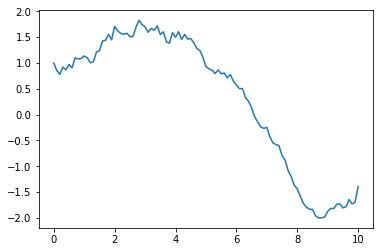

In [7]:
plt.plot(tout[0, :, 0], xout[0, :, 0])

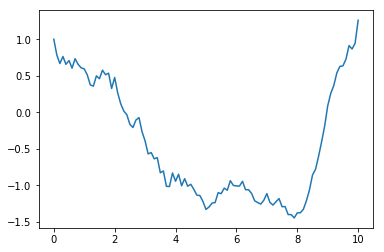

In [8]:
plt.plot(tout[0, :, 1], xout[0, :, 1])

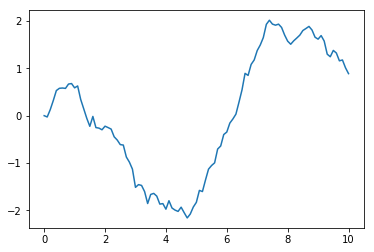

In [9]:
plt.plot(tout[1, :, 0], xout[1, :, 0])

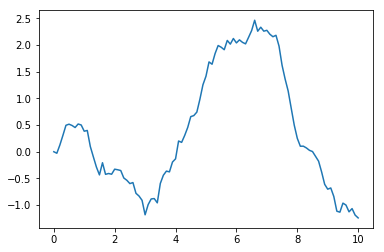

In [10]:
plt.plot(tout[1, :, 1], xout[1, :, 1])

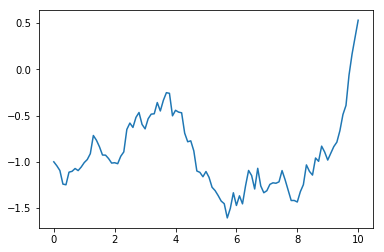

In [11]:
plt.plot(tout[2, :, 0], xout[2, :, 0])

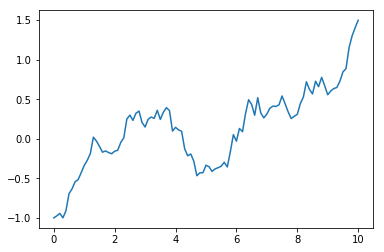

In [12]:
plt.plot(tout[2, :, 1], xout[2, :, 1])

In [22]:
print(xout.shape)

(3, 101, 2)


In [43]:
x = xout[0, 0:2, :]
print(x)

[[ 1.          1.        ]
 [ 0.85122456  0.78335908]]


In [45]:
t = tout[0, 0:2, :]
print(t)

[[ 0.   0. ]
 [ 0.1  0.1]]


In [47]:
n = 10
h = (t[1, 0] - t[0, 0]) / n
tvec = t[0, 0] + (1+np.arange(n))*h
h12 = np.sqrt(h)
gvec = np.array([0.25, 0.25])
wincs = np.random.multivariate_normal(mean = np.zeros(2), 
                                      cov = h * np.diag(np.square(gvec)), 
                                      size = n)
w = np.cumsum(wincs, axis = 0).T
print(w)
print(w.shape)
bridge = w + x[0, :]
bridge -= ((tvec - t[0, 0])/(t[1, 0]-t[0, 0]))*(w[:,n-1] + x[0, :] - x[1, :])

# concatenate the starting point to the bridge
tvec = np.concatenate((t[[index]], tvec))
bridge = np.concatenate((x[[index]], bridge))

[[ 0.00813553  0.01118725 -0.0153266   0.00332441 -0.0390462  -0.0830441
  -0.08523366 -0.19857845 -0.22049841 -0.21374232]
 [-0.01573047 -0.03994404 -0.01599724 -0.01433548 -0.02681568 -0.03733782
  -0.03061829 -0.03348829 -0.0387592  -0.10638045]]
(2, 10)


ValueError: operands could not be broadcast together with shapes (2,10) (2,) 

In [34]:
np.diag(np.square(gvec))

array([[ 0.0625,  0.    ],
       [ 0.    ,  0.0625]])